# Лабораторная 3

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt
import numpy as np

## 1. Метрики качества классификации 

### 1.1 Accuracy(точность)

В задаче классификации самой простой является метрика ***accuracy***, численно равная числу правильно предсказанных объектов к общему числу предсказаний. Однако у такой метрики есть один существенный недостаток. 

Рассмотрим простой пример. Пусть у нас есть тестовая выборка, содержащая 10000 объектов класса 1 и 100 объектов класса 2. Пусть наш классификатор ***всегда*** предсказывает класс 1. Тогда точность такого классификатора будет равна $\frac{10000}{10000 + 100} = 0.99$. 

Кажется, что это много, но задумайтесь, высокая ли предсказательная способность у нашего алгоритма. Ведь мы совсем не предсказываем 2 класс.

Метрика accuracy больше подходит в случае сбалансированных классов(классов, где доля объектов каждого класса примерно одинакова). В случае несбалансированных классов могут быть использованы другие метрики, такие как ***precision*** и ***recall***.

### 1.2 Precision и Recall

Пусть существуют два класса - положительный и отрицательный. 

Recall (полнота):
$$Recall = \frac{TP}{TP + FN}$$

Precision (точность):
$$Precision = \frac{TP}{TP + FP}$$


Где:

$TP$ - количество верно предсказанных положительных объектов (True Positives)

$TN$ - количество верно предсказанных отрицательных объектов (True Negatives)

$FP$ - количество ложно предсказанных положительных объектов (False Positives)

$FN$- количество ложно предсказанных отрицательных объектов (False Negatives)

Recall показывает, насколько хорошо модель обнаруживает положительные объектов из всего множества положительных объектов. Высокое значение recall указывает на то, что модель не пропускает много положительных объектов. 

Precision показывает, какую долю из всех объектов, которые модель предсказала как положительные, были действительно положительными. Высокое значение precision означает, что большинство предсказанных моделью положительных объектов действительно являются положительными.

Recall и precision следует рассматривать вместе в контексте задачи классификации, так как они оценивают разные качества работы модели, и иногда может потребоваться балансировка между ними в зависимости от конкретных требований задачи.

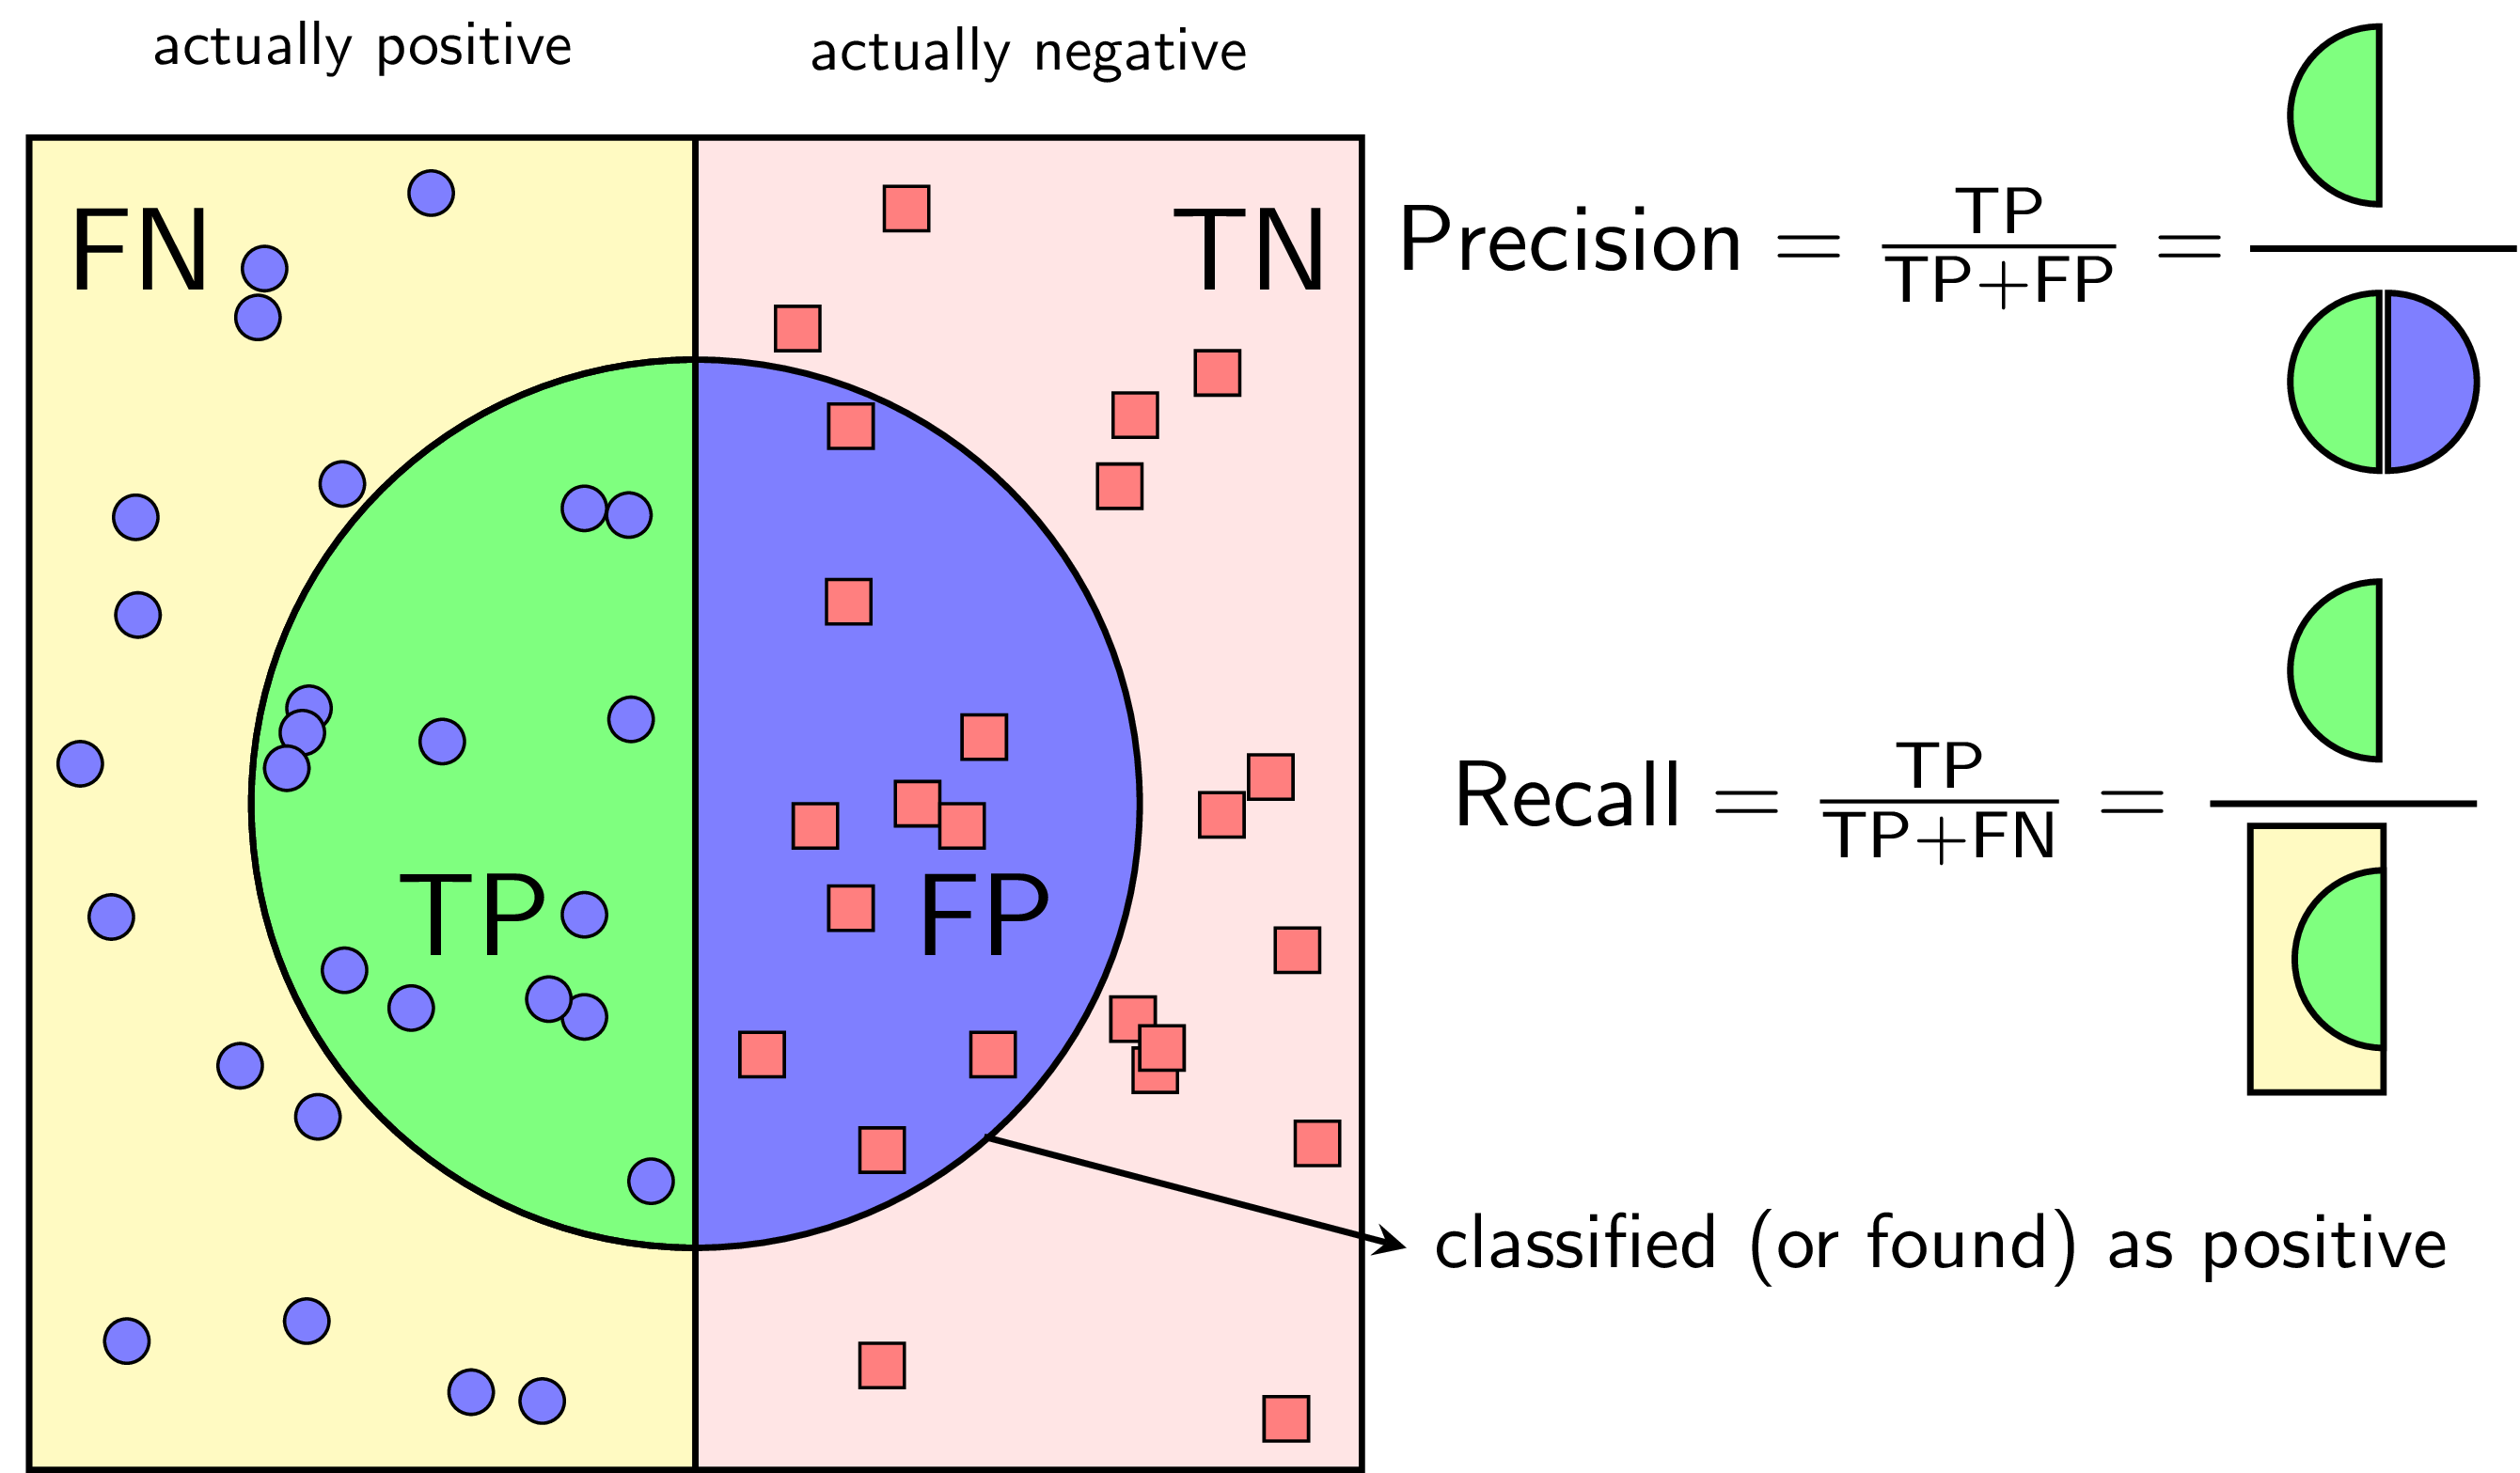

Для многоклассовой классификации precision и recall могут быть рассчитаны для каждого класса по отдельности, а затем усреднены(micro-усреднение, macro-усреднение и weighted-усреднение). Чуть позже мы поговорим про способы усреднения. 

### 1.3 F1-score

***F1-score*** - это метрика, которая объединяет в себе precision (точность) и recall (полноту) в единственное численное значение. Она является гармоническим средним между precision и recall и позволяет учесть обе метрики одновременно.

F1-score вычисляется по следующей формуле:
$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$
Эта метрика достигает своего максимального значения при точности и полноте, близких к 1. F1-score позволяет учесть баланс между полнотой и точностью модели, так как при низком значении хотя бы одной метрики, значение F1 будеть невелико. 

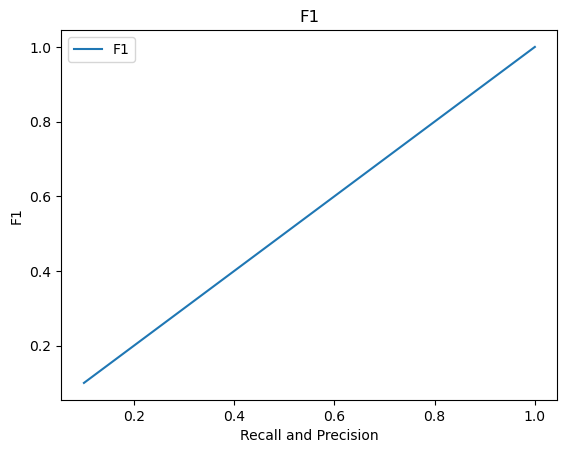

In [2]:
# значения recall, precision и F1
r = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
pr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
f1 = []
for i in range(len(r)):
    f1.append(2*r[i]*pr[i]/(r[i] + pr[i]))

# построение графика
plt.plot(r, f1, label='F1')
plt.xlabel('Recall and Precision')
plt.ylabel('F1')
plt.title('F1')
plt.legend()
plt.show()

***Взвешенная F1-score*** - это метрика, которая учитывает F1-score для каждого класса, взвешивая их по количеству экземпляров каждого класса. Она полезна при несбалансированных данных, так как она принимает во внимание как точность, так и полноту для каждого класса.

Формула для взвешенной F1-score:
$$F1_{weighted} = \frac{\sum_{i=1}^{N} w_i \cdot F1_i}{\sum_{i=1}^{N} w_i}$$

где:
- $N$ - количество классов
- $F1_i$ - F1-score для класса $i$
- $w_i$ - вес класса $i$ (число объектов класса, делённое на общее число объектов в выборке.   

### Задача1(1 балл)

1. Дан медицинский датасет, где мы классифицируем пациентов на наличие болезни(лечение которой крайне необходимо). Какая метрика (recall, precision, accuracy) лучше всего подходит для данного датасета? Почему?

2. Дан датасет сообщений, где мы хотим понять является сообщение спамом или нет. Какая метрика (recall, precision, accuracy) лучше всего подходит для данного датасета? Почему?

3. Дан датасет, где мы классифицируем рукописные цифры(на 10 классов). Какая метрика (recall, precision, accuracy) лучше всего подходит для данного датасета? Почему?

Подумайте, какие датасеты будут сбалансированны, а какие нет. Ведь от этого сильно зависит выбор метрики.  

1. Медицинский датасет (наличие болезни): В данном случае, наиболее важной метрикой является Recall. При работе с медицинскими датасетами, главной задачей является идентификация всех возможных пациентов с заболеванием, т.е., минимизация количества ложноотрицательных результатов (False Negative). Пропуск больного может иметь серьезные последствия, таким образом важность идентификатора всех реально больных высока. Однако, важно также учитывать Precision, чтобы избегать чрезмерного количества ложноположительных диагнозов, что может привести к ненужному лечению и панике среди здоровых пациентов. В некоторых ситуациях для баланса между Precision и Recall может быть рассмотрен F1-score.

2. Датасет сообщений (спам/не спам): Здесь больше подходит метрика Precision. Основная цель - максимально точно идентифицировать спам, при этом минимизируя количество легитимных сообщений, ошибочно классифицированных как спам. Ошибка типа False Positive (когда обычное сообщение помечается как спам) может привести к упущению важной информации. Тем не менее, также ситуативно может быть важен и Recall, если пропуск спам-сообщений может привести к нежелательным последствиям. Accuracy также важна, но в контексте несбалансированных датасетов (когда спама гораздо меньше, чем обычных сообщений) она может быть вводящей в заблуждение.

3. Классификация рукописных цифр: Здесь наиболее подходящей метрикой является Accuracy. Поскольку задача состоит в классификации каждого отдельного изображения как одной из десяти возможных цифр, общий процент правильно классифицированных изображений (точность) является прямым показателем успешности модели. Классификация цифр обычно предполагает сбалансированные датасеты, где каждый класс (цифра) представлен примерно одинаковым количеством образцов, что делает accuracy особенно подходящей. Однако, в случае несбалансированности, могут также рассматриваться Precision, Recall и F1-score для каждого класса в отдельности, чтобы оценить производительность модели более детализировано.

Влияние баланса классов:
- Медицинские датасеты часто являются несбалансированными, так как количество больных обычно меньше общей популяции.
- Датасеты сообщений могут быть сильно несбалансированными, где спам составляет лишь небольшую часть всех сообщений.
- Датасеты для классификации рукописных цифр обычно демонстрируют сбалансированное распределение классов.

### Задача 2(3 балла)

***Датасет MNIST*** (Modified National Institute of Standards and Technology database) — это очень популярный датасет, который состоит из изображений рукописных цифр от 0 до 9. Всего в датасете 70,000 изображений. 

Каждое изображение представляет собой черно-белую картинку размером 28x28 пикселей. Каждый пиксель представлен числом от 0 до 255, где 0 обозначает черный цвет, а 255 - белый. 

In [3]:
# Загрузка датасета MNIST
mnist = fetch_openml('mnist_784')

/opt/conda/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.1, random_state=42)

In [5]:
# Один объект выборки это просто массив чисел от 0 до 255 
X_train.iloc[0]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 42878, Length: 784, dtype: float64

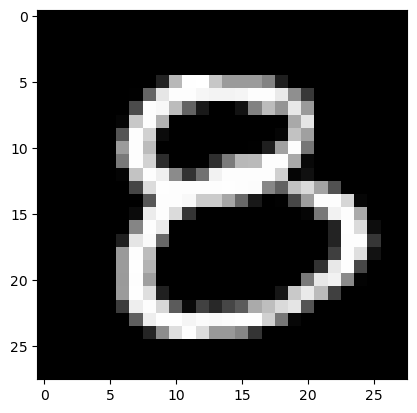

In [6]:
# Объект - это цифра, которая представлена в виде одномерного массива
plt.imshow(np.array(X_train.iloc[0]).reshape(28,28), cmap='gray')
plt.show()

1. Обучите модель k-nn на X_train. 
2. Расчитайте accuracy, recall, precision(значение каждой метрики должно превыщать 0.97) на X_test. 
3. Рассчитайте f1.
4. Ответьте, почему значения всех трёх метрикa(accuracy, recall, precision) очень похожи.

In [7]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.1, random_state=42)

# Инициализация и обучение модели k-NN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Предсказание меток классов на тестовом наборе
y_pred = knn.predict(X_test)

# Вычисление и вывод метрик accuracy, recall и precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Вычисление и вывод F1-меры
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1}')


AttributeError: 'Flags' object has no attribute 'c_contiguous'

### 1.4 ROC-AUC

$$ FPR = \frac{FP}{FP + TN} $$

$$ TPR = \frac{TP}{TP + FN} $$

***ROC-кривая*** - это график, который отображает предсказательную способность модели при различных порогах классификации. Ось X представляет долю ложно положительных классификаций (FPR), а ось Y представляет долю верно положительных классификаций (TPR), которая также называется полнотой или recall.

***AUC (Area Under the Curve)*** ROC-кривой - это численное значение, равное площади под ROC-кривой. 

- AUC ROC близок к 1, если модель хорошо разделяет классы
- AUC ROC близок к 0.5, если модель случайно классифицирует классы

<div>
<img src="attachment:roc-auc.png" width="500"/>
</div>

### Задача(3)(2 балла)

1. Постройте Roc кривую для датасета Wisconsin Breast Cancer
2. Расчитайте площадь ней (AUC)

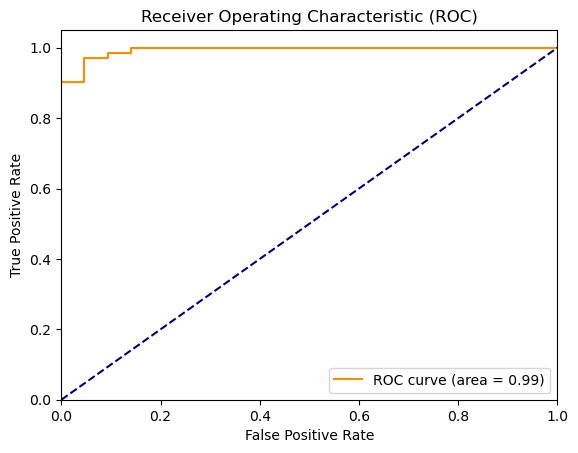

In [8]:
# Импорт необходимых библиотек
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Загрузка датасета Wisconsin Breast Cancer
data = load_breast_cancer()
X = data.data
y = data.target

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели SVM
model = SVC(probability=True)
model.fit(X_train, y_train)

# Получение вероятностей принадлежности к классам
y_probs = model.predict_proba(X_test)[:, 1]

# Расчет ROC кривой и площади под ней (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### 2.1 Отбор признаков

***Алгоритм полного перебора*** признаков включает в себя исчерпывающее перебор всех возможных комбинаций признаков для выбора наилучшего подмножества признаков. Процесс поиска наилучшего подмножества заключается в оценке каждой возможной комбинации признаков на основе некоторого критерия. Например, это может быть качество модели (например, precision, recall, F1-score, ROC-AUC) при использовании конкретной комбинации признаков.

Однако, алгоритм полного перебора признаков довольно затратен по вычислительным ресурсам, так как он требует оценки всех комбинаций признаков. При $n$ признаках существует $2^n - 1$ возможных комбинаций (включая пустое множество и полное множество), что приводит к экспоненциальному росту количества комбинаций при увеличении числа признаков. Поэтому алгоритм полного перебора признаков эффективен только при небольшом количестве признаков.

***Алгоритм жадного перебора признаков*** (greedy feature selection) - это метод отбора признаков, который последовательно добавляет или удаляет признаки, основываясь на некотором критерии оценки. Он позволяет найти подмножество наиболее информативных признаков, основываясь на оценке производительности модели.

Есть два основных подхода жадного перебора признаков:
1. Прямой жадный отбор:

- Начинается с пустого набора признаков.

- Последовательно добавляются признаки согласно некоторому критерию (например, улучшение производительности модели).

- Процесс остановки зависит от выбранного критерия, например, можно остановиться, когда производительность модели перестает улучшаться.

2. Обратный жадный отбор:

- Начинается с полного набора признаков.

- Последовательно удаляются признаки, основываясь на некотором критерии (например, уменьшение производительности модели).

- Процесс остановки зависит от выбранного критерия, например, можно остановиться, когда производительность модели начинает ухудшаться.

### Задача4(3 балла)

Постройте алгоритм жадного перебора(прямой) для предыдущего датасета. В качестве модели, выберите модель из прошлой задачи. В качестве метрики используйте accuracy. 

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Загрузка данных
data = load_breast_cancer()
X = data.data
y = data.target

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Инициализация для отслеживания наилучших признаков
best_features = []
remaining_features = list(range(X_train.shape[1]))
best_accuracy = 0

# Алгоритм прямого жадного перебора
while remaining_features:
    feature_accuracies = []
    
    for feature in remaining_features:
        current_features = best_features + [feature]
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train[:, current_features], y_train)
        predictions = knn.predict(X_test[:, current_features])
        accuracy = accuracy_score(y_test, predictions)
        feature_accuracies.append((accuracy, feature))
        
    feature_accuracies.sort(reverse=True)  # Сортировка по убыванию точности
    best_feature_accuracy, best_feature = feature_accuracies[0]
    
    if best_feature_accuracy > best_accuracy:
        print(f"New best feature: {best_feature} with accuracy: {best_feature_accuracy}")
        best_accuracy = best_feature_accuracy
        best_features.append(best_feature)
        remaining_features.remove(best_feature)
    else:
        break  # Прервать цикл, если точность не улучшается

print(f"Best features set: {best_features} with accuracy: {best_accuracy}")


New best feature: 23 with accuracy: 0.9239766081871345
New best feature: 21 with accuracy: 0.9473684210526315
New best feature: 3 with accuracy: 0.9532163742690059
New best feature: 22 with accuracy: 0.9590643274853801
Best features set: [23, 21, 3, 22] with accuracy: 0.9590643274853801


### 2.2 Линейная зависимость между признаками

Линейная зависимость между признаками означает, что два или несколько признаков в наборе данных линейно связаны друг с другом. Это означает, что один признак может быть выражен как линейная комбинация других признаков. Наличие линейной зависимости может привести к проблемам при обучении модели, поскольку это может привести к неустойчивости оценок коэффициентов и усложнить интерпретацию весов, а также может привести к переобучению модели.

Матрица корреляции - это таблица, в которой отображены коэффициенты корреляции между парами признаков в наборе данных. Коэффициент корреляции измеряет степень линейной зависимости между двумя переменными. Диапазон значений коэффициента корреляции лежит между -1 и 1:

- Значение близкое к 1 означает сильную прямую линейную зависимость

- Значение близкое к -1 означает сильную обратную линейную зависимость

- Значение близкое к 0 означает отсутствие линейной зависимости.

Анализ матрицы корреляции помогает выявить линейные зависимости между признаками. Если два или более признака имеют высокий коэффициент корреляции, это может быть признаком наличия мультиколлинеарности, что указывает на сильную линейную зависимость между признаками. Мультиколлинеарность также может создать проблемы при интерпретации весов модели.

Если обнаружена высокая корреляция между признаками, возможны следующие действия:

1. Удаление одного из пары сильно скоррелированных признаков

2. Преобразование признаков, например, с помощью методов главных компонент или регуляризации, чтобы уменьшить влияние мультиколлинеарности.

Однако, важно помнить, что корреляция не всегда означает причинно-следственную связь между признаками, и дополнительный анализ требуется для полного понимания взаимосвязей в данных.

## 3. Кросс-валидация

***Кросс-валидация*** (cross-validation) - это метод оценки производительности модели, который позволяет оценить, насколько хорошо модель обобщает данные, не прибегая к разделению исходного набора данных на обучающую и тестовую выборки. Вместо этого данные разбиваются на несколько подмножеств, называемых блоками или складками (folds), и выполняется несколько итераций обучения и тестирования модели на различных комбинациях этих блоков.

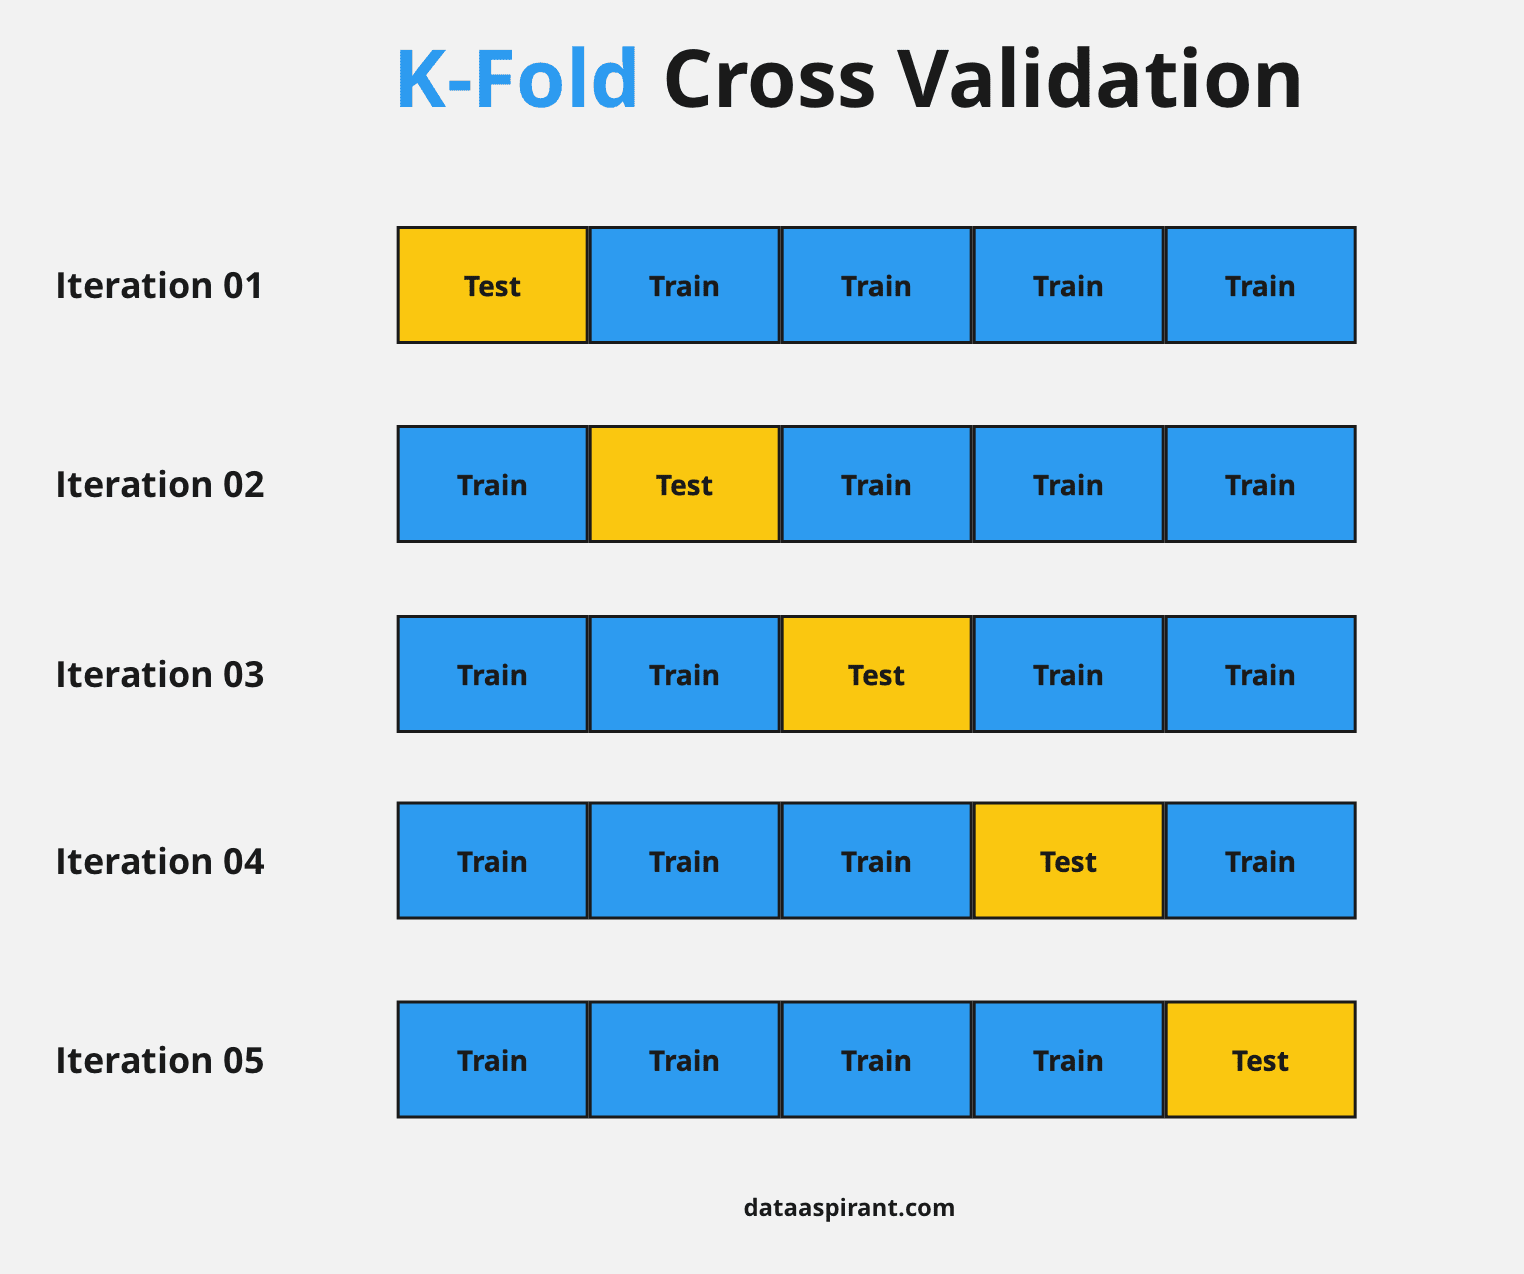

### Задача 5(1 балл)

1. Рассчитайте точность работы k-nn с помощью cross_val_score. 
2. Постройте график зависимости средней точности от числа ближайщих соседей(1, 2, 3... 10). 

Средняя точность для 1 ближайших соседей: 0.9643933766635715
Средняя точность для 2 ближайших соседей: 0.9671711544413494
Средняя точность для 3 ближайших соседей: 0.966621788919839
Средняя точность для 4 ближайших соседей: 0.9638409161250386
Средняя точность для 5 ближайших соседей: 0.9627282575054161
Средняя точность для 6 ближайших соседей: 0.9593856391210152
Средняя точность для 7 ближайших соседей: 0.9599458372021046
Средняя точность для 8 ближайших соседей: 0.9582760755184154
Средняя точность для 9 ближайших соседей: 0.9566109563602601
Средняя точность для 10 ближайших соседей: 0.954942742185082


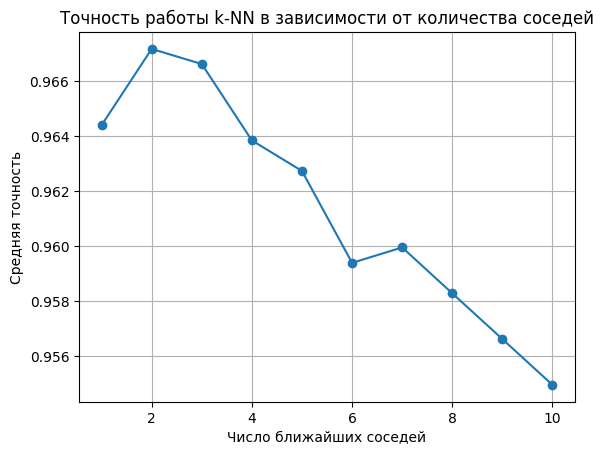

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits

# Загрузка датасета
digits = load_digits()
X, y = digits.data, digits.target

# Массив для хранения средних точностей
average_accuracies = []

# Перебираем число соседей от 1 до 10
for n_neighbors in range(1, 11):
    # Инициализация модели KNeighborsClassifier с текущим значением соседей
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Используем cross_val_score для получения массива результатов
    scores = cross_val_score(model, X, y, cv=5)
    
    # Сохраняем среднюю точность для текущего количества соседей
    average_accuracy = np.mean(scores)
    average_accuracies.append(average_accuracy)
    
    print(f"Средняя точность для {n_neighbors} ближайших соседей: {average_accuracy}")

# Построение графика зависимости средней точности от числа ближайших соседей
plt.plot(range(1, 11), average_accuracies, marker='o', linestyle='-')
plt.xlabel('Число ближайших соседей')
plt.ylabel('Средняя точность')
plt.title('Точность работы k-NN в зависимости от количества соседей')
plt.grid(True)
plt.show()


## 4. Критерий Акаике

***Критерий Акаике (Akaike Information Criterion, AIC)*** - это мера относительной эффективности статистических моделей. Он был разработан японским статистиком Хироаки Акаике и широко используется в статистике и машинном обучении для сравнения и выбора между различными моделями на основе их пригодности к описанию данных и сложности модели.

Формула для вычисления критерия Акаике следующая:

$$AIC = 2k - 2ln(L)$$

где:

- k - количество параметров в модели

- L - значение функции правдоподобия для модели

Критерий Акаике штрафует модели с большим количеством параметров, поскольку увеличение количества параметров может привести к переобучению и ухудшению обобщающей способности модели. Это отражается в первом слагаемом $2k$, которое штрафует модели с большим числом параметров.

Второе слагаемое $2ln(L)$ представляет собой меру подгонки модели к данным. Чем выше значение функции правдоподобия (L) для модели, тем меньше данное слагаемое и, следовательно, тем лучше модель описывает данные.

Цель состоит в минимизации значения AIC. Сравнение моделей проводится на основе их AIC: модель с меньшим AIC считается более предпочтительной.

Однако, важно отметить, что в контексте выбора моделей сравнение по AIC лучше проводить для моделей, построенных на одном и том же наборе данных. AIC предоставляет намерение сравнения моделей и выбора наиболее адекватной модели в данном наборе данных, но не дает нам информации о том, насколько хорошо модели будут работать на новых данных.